In [333]:
import numpy as np
import scipy as sp
import xarray as xa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

from pyunicorn.timeseries import RecurrencePlot, JointRecurrencePlot
from pyunicorn.timeseries.surrogates import Surrogates
from pyunicorn.core import Network

from geopy.distance import geodesic, great_circle

ValueError: The input coordinate is not sorted in increasing order along axis 0. This can lead to unexpected results. Consider calling the `sortby` method on the input DataArray. To plot data with categorical axes, consider using the `heatmap` function from the `seaborn` statistical plotting library.

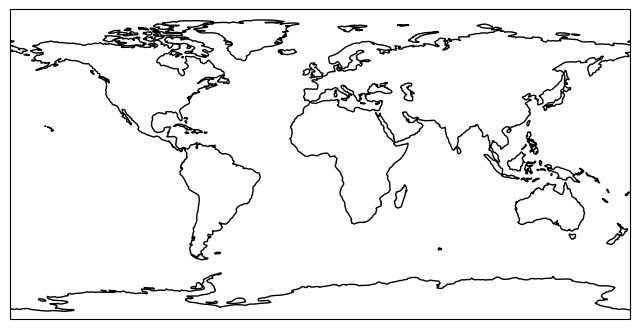

In [371]:
# load and filter the dataset
air = xa.open_dataset("../data/air.mon.mean.nc").air
air = air[(air.time.dt.month > 11) | (air.time.dt.month < 3),8:22, np.arange(120, 160)%144]

temps = air.to_numpy().reshape(len(air.time), -1).T.astype("float64")

plt.figure(figsize=(8, 5))

ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()

air[0].plot.pcolormesh(ax=ax, transform=ccrs.PlateCarree(), cmap="Blues")

plt.show()

In [357]:
lat = np.repeat(air.lat.to_numpy(), 14)
lat

array([75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. , 75. ,
       75. , 75. , 75. , 72.5, 72.5, 72.5, 72.5, 72.5, 72.5, 72.5, 72.5,
       72.5, 72.5, 72.5, 72.5, 72.5, 72.5, 70. , 70. , 70. , 70. , 70. ,
       70. , 70. , 70. , 70. , 70. , 70. , 70. , 70. , 70. , 67.5, 67.5,
       67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5, 67.5,
       67.5, 65. , 65. , 65. , 65. , 65. , 65. , 65. , 65. , 65. , 65. ,
       65. , 65. , 65. , 65. , 62.5, 62.5, 62.5, 62.5, 62.5, 62.5, 62.5,
       62.5, 62.5, 62.5, 62.5, 62.5, 62.5, 62.5, 60. , 60. , 60. , 60. ,
       60. , 60. , 60. , 60. , 60. , 60. , 60. , 60. , 60. , 60. , 57.5,
       57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5, 57.5,
       57.5, 57.5, 55. , 55. , 55. , 55. , 55. , 55. , 55. , 55. , 55. ,
       55. , 55. , 55. , 55. , 55. , 52.5, 52.5, 52.5, 52.5, 52.5, 52.5,
       52.5, 52.5, 52.5, 52.5, 52.5, 52.5, 52.5, 52.5, 50. , 50. , 50. ,
       50. , 50. , 50. , 50. , 50. , 50. , 50. , 50

In [49]:
np.seterr(all="ignore");

# def recurrence_plot(y, threshold=None, recurrence_rate=0.1):
#     """
#
#     :param y: (m, n) array or (m,) array
#         array of m observations in n dimensional space
#         for scalar timeseries with shape (m), a second axis is introduced by calling np.expand_dims(y, axis=1)
#     :param threshold:
#     :param recurrence_rate:
#     :return:
#     """
#
#     # convert to numpy array
#     y = np.asarray(y)
#
#     # expand dims for scalar time series
#     if len(y.shape) == 1:
#         y = np.expand_dims(y, axis=1)
#
#     # calculate the pairwise distance
#     rp = sp.spatial.distance.squareform(sp.spatial.distance.pdist(y, metric="euclidean"))
#
#     # calculate the threshold
#     threshold = threshold if threshold is not None else np.quantile(rp, recurrence_rate)
#
#     # return thresholded distance matrix
#     return rp < threshold, threshold

In [51]:
def pearson (yi, yj):
    return sp.stats.pearsonr(yi, yj)[0]

def rmd (yi, yj, normalize=True, recurrence_rate=0.1, **kwargs):

    # generate the recurrence plots
    # TODO: the function uses the supremum norm, is this okay?
    irp = RecurrencePlot(yi, normalize=normalize, recurrence_rate=recurrence_rate, silence_level=10, **kwargs)
    jrp = RecurrencePlot(yj, normalize=normalize, recurrence_rate=recurrence_rate, silence_level=10, **kwargs)

    # get the recurrence matrices
    irp = irp.recurrence_matrix().copy()
    jrp = jrp.recurrence_matrix().copy()

    # calculate the column recurrence rate
    Pij = np.mean(irp*jrp, axis=1)
    Pi  = np.mean(irp, axis=1)
    Pj  = np.mean(jrp, axis=1)

    # calculate the recurrence based measure of dependence
    rmd = np.sum(Pij/(Pi*Pj))

    return rmd if np.isfinite(rmd) else 0

def create_surrogates(y, S, threshold=None, dimension=1, delay=0):
    surrogate_generator = Surrogates(y, silence_level=100)
    surrogate_generator.clear_cache()
    surrogates = np.array([surrogate_generator.twin_surrogates(np.array([y]), dimension, delay, threshold) for s in range(S)]).squeeze()
    return surrogates if S > 1 else np.array([surrogates])

def correlation_matrix(ys, n_surrogates=10, recurrence_rate=0.1, metric=pearson, **kwargs):

    # how many individual time series
    N = len(ys)

    # empty matrix for correlation metric
    C = np.zeros((N, N))
    # empty matrix for significance
    S = np.zeros((N, N))

    for i ,yi in enumerate(ys):
        for j, yj in enumerate(ys):

            if (i > j):

                # calculate the metric for this pair of yi, yj
                C[i, j] = metric(yi, yj, **kwargs)

                # retrieve the recurrence threshold
                rp = RecurrencePlot(yi, recurrence_rate=recurrence_rate, silence_level=10)
                threshold = rp.threshold_from_recurrence_rate(rp.distance_matrix(1, "supremum"), recurrence_rate)
                # TODO: the function uses the supremum norm, is this okay?

                # create S surrogates of the series yj
                surrogates = create_surrogates(yj, n_surrogates, threshold=threshold)

                # for S surrogates, calculate the metric
                m = [metric(yi, s) for s in surrogates]
                q = np.quantile(m, [0.025, 0.975])

                # map whether effect is statistically significant
                S[i, j] = (C[i, j] < q[0]) ^ (q[1] < C[i, j])
                S[i, j] *= abs(np.mean(m) - C[i, j])

    return C + C.T, S + S.T

def adjecency_matrix(C, S, p = 0.05, binary=True):
    S = S > np.quantile(S, 1 - p)
    return C*S != 0 if binary else C*S

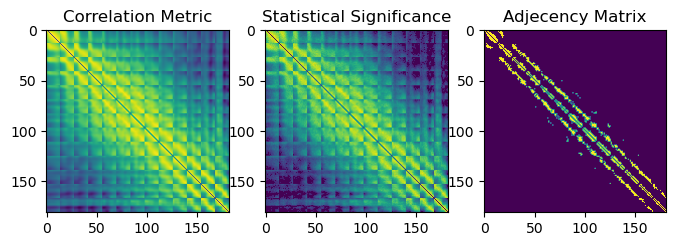

CPU times: user 53.1 s, sys: 1 s, total: 54.1 s
Wall time: 55.7 s


In [78]:
%%time

C, S = correlation_matrix(temps, metric=pearson)
A = adjecency_matrix(C, S)

plt.figure(figsize=(8, 3))
ax = plt.subplot(131)
ax.imshow(C)
ax.set_title("Correlation Metric")
ax = plt.subplot(132)
ax.imshow(S)
ax.set_title("Statistical Significance")
ax = plt.subplot(133)
ax.imshow(A)
ax.set_title("Adjecency Matrix")
plt.show()

In [154]:
def distance_matrix (Ni, Nj):
    return np.fromfunction(lambda i, j: abs(i - j), (Ni, Nj))

D = distance_matrix(N, N)

In [195]:
N = temps.shape[0]

lat = air.lat.to_numpy()
lon = air.lon.to_numpy()

D = np.zeros_like(A, dtype="float")
for i in range(N):
    for j in range(N):
        lat_i = lat[i // 14]
        lon_i = lon[i % 14]
        lat_j = lat[j // 14]
        lon_j = lon[j % 14]
        D[i, j] = great_circle([lat_i, lon_i], [lat_j, lon_j]).km

D = D + D.T

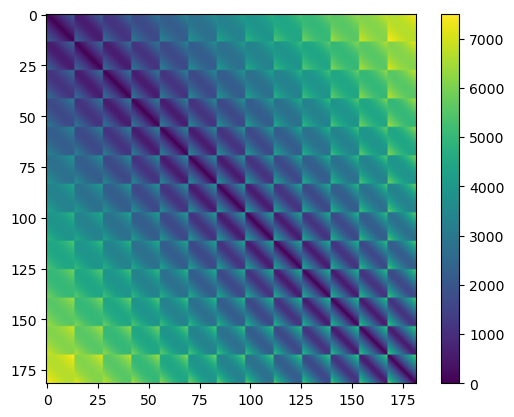

7509.448936242686

In [206]:
plt.imshow(D)
plt.colorbar()
plt.show()
np.max(D)

In [202]:
def link_distances(A, D):
    A = A[np.triu_indices(len(A), k=1)]
    D = D[np.triu_indices(len(D), k=1)]
    return D[A == 1].flatten()

In [331]:
def create_surrogate_adjacency_matrix(adjacency_matrix, distance_matrix, **kwargs):

    # calculate the link distances in the adjacency matrix
    d = link_distances(adjacency_matrix, distance_matrix)

    # calculate probability that a link distance is seen
    counts_seen, bins = np.histogram(d, **kwargs)
    counts_base, _    = np.histogram(distance_matrix[np.triu_indices(distance_matrix.shape[0], k=1)], bins=bins)

    # maximum allowed distance range in the surrogate
    dmin = np.min(d)
    dmax = np.max(d)

    # center the bins
    bins = (bins[:-1] + bins[1:])/2

    # calculate the link probability per distance
    probs = np.nan_to_num(counts_seen/counts_base, nan=0, posinf=0, neginf=0)

    S = np.zeros_like(adjacency_matrix)
    for i in range(S.shape[0]):
        for j in range(S.shape[1]):

            if i > j:
                # get the bin index of the distance matrix at this location
                bin_index = np.argmin(np.abs(bins - distance_matrix[i, j]))

                # get the probability that for a link distance
                prob = probs[bin_index]
                prob *= (dmin < distance_matrix[i, j] < dmax)

                # randomly connect the nodes based on the distance
                S[i, j] = True if np.random.random() < prob else False

    return S + S.T

In [318]:
%%time
S = create_surrogate_adjacency_matrix(A, D, bins=20)

CPU times: user 155 ms, sys: 5.2 ms, total: 160 ms
Wall time: 167 ms


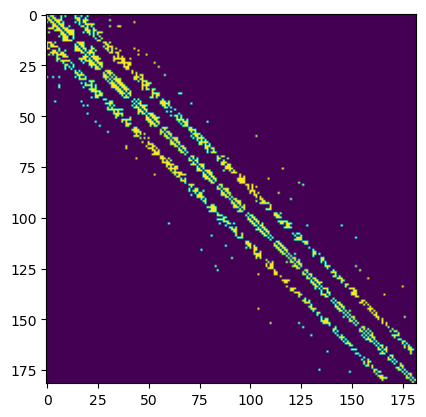

In [319]:
plt.imshow(S)

In [320]:
np.mean(S)

0.049812824538099265

In [321]:
np.mean(A)

0.04999396208187417

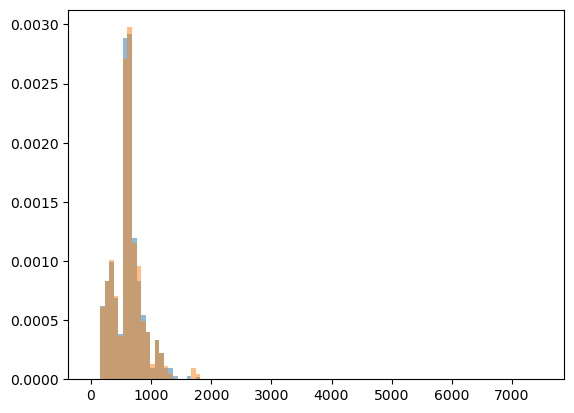

In [322]:
plt.hist(link_distances(A, D), alpha=0.5, density=True, bins=np.linspace(0, 7500, 100))
plt.hist(link_distances(S, D), alpha=0.5, density=True, bins=np.linspace(0, 7500, 100))
plt.show()

In [328]:
net = Network(adjacency=A)

Calculating closeness...


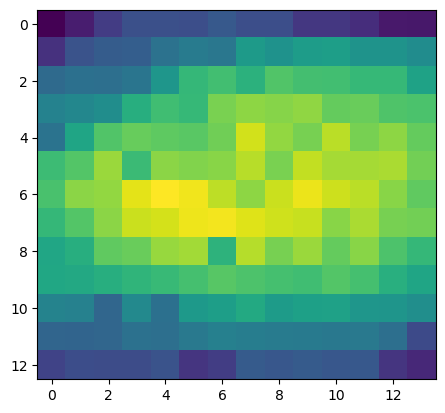

In [332]:
plt.imshow(net.closeness().reshape(13, 14))

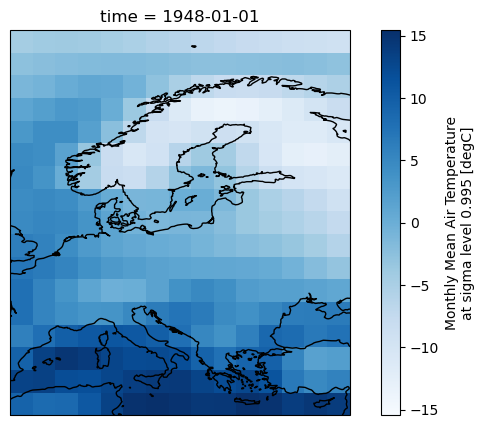